In [16]:
import pandas as pd
import re
import json
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Function Reputation Scoring

In [17]:
# source query: https://4221960800361869.9.gcp.databricks.com/sql/editor/10f35f0f-929d-44e7-a1c6-12d984f0c8f1?o=4221960800361869
df = pd.read_csv('/content/drive/MyDrive/Dec 4-8 AI Agents Hackathon/top_100_fxns_last_3_months.csv')
df.drop(columns=['block_timestamp_utc','row_number'],inplace=True)
df.head()

,receiver_id,method_name,converted_into_receipt_id,args_parsed,n_txs,n_signers,total_gas,avg_gas,days_since_first_block
0,earn.kaiching,claim,44YrcFMKZ2hQqXkkQCi5c85pcH5STBPaum2zFWKGXZWc,"{""memo"": ""sws:609e7be4382aac59f1fd05605e731866...",61312807,2461837,1.840000e+21,30000000000000,100
1,inscription.near,inscribe,GZN7VwqkasMR2ZdVfxR8Q4jm9KLPddRePz6cxQaZB9m8,"{""p"": ""nrc-20"", ""op"": ""mint"", ""amt"": ""10000000...",42576104,23877,2.970000e+21,69872881991038,8
2,token.sweat,ft_transfer,BRZACW8iAuCATMj9oddTnQ7KpaJ26mF24DjSwmzFQwYx,"{""receiver_id"":""6d1f50ecb17ef17593d81382548320...",24262250,1946753,4.733223e+20,19508592362460,468
3,aurora,submit,Hqr9CUZ13GyGH9cvvuWM5jtA1ZKD5N3UVsPjh8eqVW7M,�у#Q��,12916671,60,3.850000e+21,298231153367616,938
4,token.sweat,record_batch,Hmoieijy1qTQixk6Q84ZNgyCcGFiKTetDD5PiixsCYkj,"{""steps_batch"":[[""1c3fc81c40dc4f9fe21ea2c95d20...",2312665,1,6.937995e+20,299999999999999,449


In [18]:
def scale_fields(df,log_scale_columns = ['n_txs','n_signers','total_gas'],score_columns=['n_txs','n_signers','total_gas','avg_gas','days_since_first_block'],invert_score = ['avg_gas']):
  # first log scale the absolute number columns due to long tail
  df[log_scale_columns] = df[log_scale_columns].apply(np.log1p)
  # then min-max scale the columns so they're on the same magnitude
  scaler = MinMaxScaler()
  df[score_columns] = scaler.fit_transform(df[score_columns])

  # invert scores for avg_gas since we assume that lower gas cost is better
  df[invert_score] = 1-df[invert_score]

  # sum total scores and then min-max again to scale between 0 and 1
  df['reputation_score'] = df[score_columns].sum(axis=1)
  df[['reputation_score']] = scaler.fit_transform(df[['reputation_score']])*100
  df['reputation_score'] = round(df['reputation_score'],2)
  df['reputation_ranking'] = df['reputation_score'].rank(method='dense',ascending=False)
  return df

In [19]:
scaled_df = scale_fields(df)
scaled_df.sort_values(by='reputation_score',ascending=False,inplace=True)
scaled_df.head()

,receiver_id,method_name,converted_into_receipt_id,args_parsed,n_txs,n_signers,total_gas,avg_gas,days_since_first_block,reputation_score,reputation_ranking
2,token.sweat,ft_transfer,BRZACW8iAuCATMj9oddTnQ7KpaJ26mF24DjSwmzFQwYx,"{""receiver_id"":""6d1f50ecb17ef17593d81382548320...",0.897247,0.983260,0.786065,0.965044,0.376432,100.00,1.0
0,earn.kaiching,claim,44YrcFMKZ2hQqXkkQCi5c85pcH5STBPaum2zFWKGXZWc,"{""memo"": ""sws:609e7be4382aac59f1fd05605e731866...",1.000000,1.000000,0.924644,0.928948,0.075286,97.81,2.0
1,inscription.near,inscribe,GZN7VwqkasMR2ZdVfxR8Q4jm9KLPddRePz6cxQaZB9m8,"{""p"": ""nrc-20"", ""op"": ""mint"", ""amt"": ""10000000...",0.959578,0.669428,0.973513,0.791764,0.000000,83.01,3.0
9,app.nearcrowd.near,claim_assignment,EcMhyCP2ziRdUNWZ7UZ7Lwo8xCivUUoZcnbt9ekbRR8Y,"{""task_ordinal"":1,""bid"":""500000000000000000000...",0.577610,0.467056,0.535646,0.928948,0.801964,80.71,4.0
12,token.sweat,ft_transfer_call,HdorNsqPwfpQtAckZdg3pDGvk3TDr9MSLe4yjAqUADaw,"{""receiver_id"":""jars.sweat"",""amount"":""47200000...",0.543518,0.890608,0.520972,0.910577,0.376432,78.80,5.0


In [ ]:
sns.histplot(data=scaled_df,x='reputation_score')

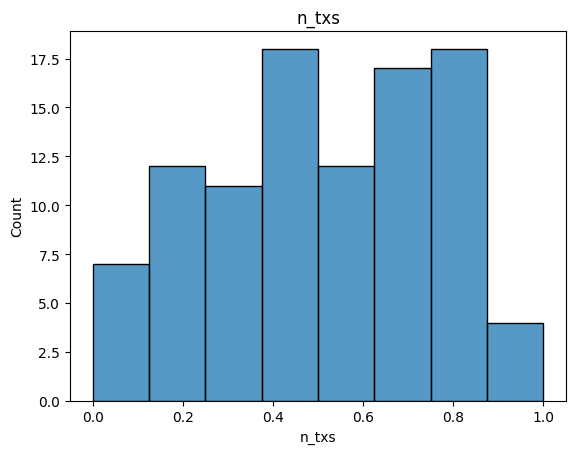

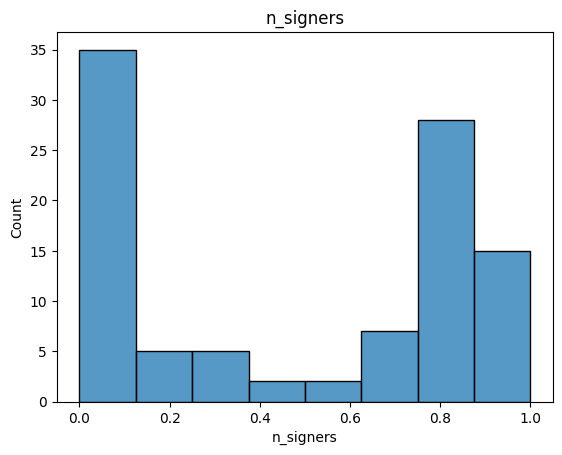

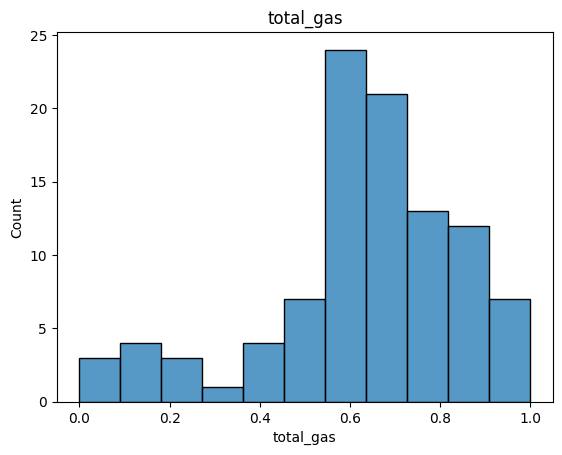

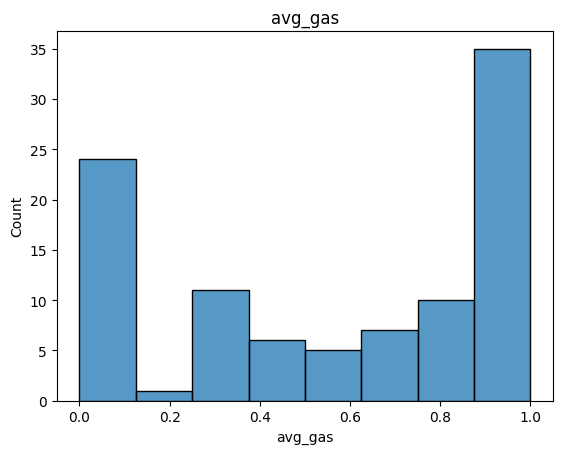

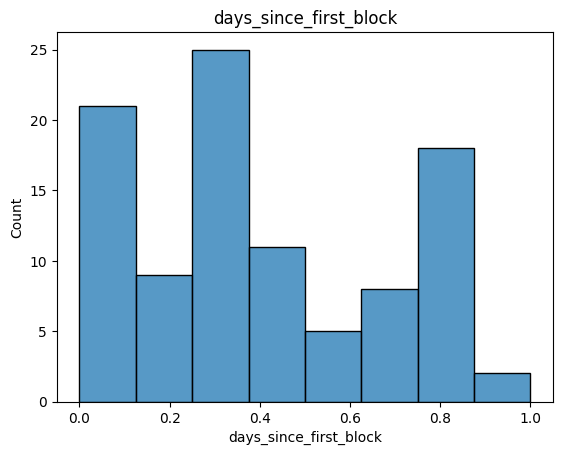

In [ ]:
# check the histogram of underlying components
for i in ['n_txs','n_signers','total_gas','avg_gas','days_since_first_block']:
  sns.histplot(data=scaled_df,x=i)
  plt.title(i)
  plt.show()

In [ ]:
# sample reputation score
scaled_df[['receiver_id','method_name','reputation_score','reputation_ranking']].head(15)

,receiver_id,method_name,reputation_score,reputation_ranking
2,token.sweat,ft_transfer,100.000000,1.0
0,earn.kaiching,claim,97.808578,2.0
1,inscription.near,inscribe,83.010932,3.0
9,app.nearcrowd.near,claim_assignment,80.711900,4.0
12,token.sweat,ft_transfer_call,78.798707,5.0
6,token.sweat,storage_deposit,76.823941,6.0
11,tge-lockup.sweat,claim,75.541812,7.0
7,embr.playember_reserve.near,earn_sprk,74.516434,8.0
17,app.nearcrowd.near,submit_review,73.590769,9.0
19,app.nearcrowd.near,submit_approved_solution,73.561166,10.0


# Langchain Function Conversion

In [4]:
!pip install fastapi nest-asyncio pyngrok uvicorn
!pip install openai langchain

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.9/92.9 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.7/59.7 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 7.7 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.5.0
    Uninstalling typing_extensions-4.5.0:
      Successfully uninstalled typing_extensions-4.5.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
tensorflow-probability 0.22.0 requires typing-extensions<4.6.0, but you have typing-extensions 4.8.0 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 221.4/221.4 kB 3.4 MB/

In [13]:
import json
import re
import pandas as pd
import os
import openai
from pydantic import BaseModel, Field
from langchain.utils.openai_functions import convert_pydantic_to_openai_function
from langchain.prompts import ChatPromptTemplate
from langchain.chat_models import ChatOpenAI
from langchain.output_parsers.openai_functions import JsonOutputFunctionsParser

from google.colab import userdata
api_key = userdata.get('openapi_key')
# documentation: https://js.langchain.com/docs/modules/model_io/models/chat/how_to/function_calling

In [20]:
df = scaled_df
df = df.sort_index()
df.head()

,receiver_id,method_name,converted_into_receipt_id,args_parsed,n_txs,n_signers,total_gas,avg_gas,days_since_first_block,reputation_score,reputation_ranking
0,earn.kaiching,claim,44YrcFMKZ2hQqXkkQCi5c85pcH5STBPaum2zFWKGXZWc,"{""memo"": ""sws:609e7be4382aac59f1fd05605e731866...",1.000000,1.000000,0.924644,9.289482e-01,0.075286,97.81,2.0
1,inscription.near,inscribe,GZN7VwqkasMR2ZdVfxR8Q4jm9KLPddRePz6cxQaZB9m8,"{""p"": ""nrc-20"", ""op"": ""mint"", ""amt"": ""10000000...",0.959578,0.669428,0.973513,7.917636e-01,0.000000,83.01,3.0
2,token.sweat,ft_transfer,BRZACW8iAuCATMj9oddTnQ7KpaJ26mF24DjSwmzFQwYx,"{""receiver_id"":""6d1f50ecb17ef17593d81382548320...",0.897247,0.983260,0.786065,9.650444e-01,0.376432,100.00,1.0
3,aurora,submit,Hqr9CUZ13GyGH9cvvuWM5jtA1ZKD5N3UVsPjh8eqVW7M,�у#Q��,0.827375,0.243718,1.000000,6.085803e-03,0.761047,67.62,13.0
4,token.sweat,record_batch,Hmoieijy1qTQixk6Q84ZNgyCcGFiKTetDD5PiixsCYkj,"{""steps_batch"":[[""1c3fc81c40dc4f9fe21ea2c95d20...",0.636722,0.000000,0.825096,3.330669e-15,0.360884,39.51,53.0


In [40]:
#filter down to kaiching, sweat, and price
df = df[df['receiver_id'].str.contains('kaiching|sweat|price',case=False)].reset_index()
df

,index,receiver_id,method_name,converted_into_receipt_id,args_parsed,n_txs,n_signers,total_gas,avg_gas,days_since_first_block,reputation_score,reputation_ranking
0,0,earn.kaiching,claim,44YrcFMKZ2hQqXkkQCi5c85pcH5STBPaum2zFWKGXZWc,"{""memo"": ""sws:609e7be4382aac59f1fd05605e731866...",1.000000,1.000000,0.924644,9.289482e-01,0.075286,97.81,2.0
1,2,token.sweat,ft_transfer,BRZACW8iAuCATMj9oddTnQ7KpaJ26mF24DjSwmzFQwYx,"{""receiver_id"":""6d1f50ecb17ef17593d81382548320...",0.897247,0.983260,0.786065,9.650444e-01,0.376432,100.00,1.0
2,4,token.sweat,record_batch,Hmoieijy1qTQixk6Q84ZNgyCcGFiKTetDD5PiixsCYkj,"{""steps_batch"":[[""1c3fc81c40dc4f9fe21ea2c95d20...",0.636722,0.000000,0.825096,3.330669e-15,0.360884,39.51,53.0
3,6,token.sweat,storage_deposit,3Pm2eJS7aWqSu637grNE3Jh9m3sqe5qkMj5v5SKZKRXW,"{""account_id"":""cfeec460b81cace9dd9bf4a2b24bcbf...",0.598151,0.712672,0.554627,9.288819e-01,0.376432,76.82,6.0
4,8,wallet.kaiching,storage_deposit,6ZLfYcUQPnHkjy3cxD7rCwe858EUiGtmYbD6kbqC189Y,"{""account_id"": ""33mqis2b91yu.users.kaiching""}",0.579227,0.049428,0.660020,6.881099e-01,0.090835,46.29,38.0
5,10,wallet.kaiching,ft_transfer_call,G2kMJ6ACTuwwe1YgGmbyqRQMbhe6WbABceVEcxjspURp,"{""receiver_id"": ""earn.kaiching"", ""amount"": ""24...",0.571682,0.000000,0.765202,0.000000e+00,0.075286,28.15,75.0
6,11,tge-lockup.sweat,claim,GorjcYCBFbb7tNxvzDvzMyTsNGJU3MaALjiRzyytwaCA,{},0.556598,0.878856,0.639182,6.881064e-01,0.361702,75.54,7.0
7,12,token.sweat,ft_transfer_call,HdorNsqPwfpQtAckZdg3pDGvk3TDr9MSLe4yjAqUADaw,"{""receiver_id"":""jars.sweat"",""amount"":""47200000...",0.543518,0.890608,0.520972,9.105768e-01,0.376432,78.80,5.0
8,13,priceoracle.near,report_prices,CWvvZK9az2Ktdc84Xgttt7DUoNcTZdV3cFo6gWDJApge,"{""prices"":[{""asset_id"":""wrap.near"",""price"":{""m...",0.524771,0.078342,0.539127,8.601372e-01,0.627660,61.86,16.0
9,24,jars.sweat,claim_total,8Abof1FokGLTWnF7wP8XWWZqrH95szkMLEmEun7jWay1,"{""detailed"":true}",0.373624,0.766610,0.399951,8.601187e-01,0.040917,56.63,22.0


In [34]:
def description_from_function(text,api_key=api_key):
  model = ChatOpenAI(openai_api_key=api_key,temperature=0,model='gpt-3.5-turbo')
  prompt = ChatPromptTemplate.from_messages([
    ("system", "Think carefully, and then create conscise description of the function. Ignore alphanumeric strings."),
    ("user", "{input}")])
  chain = prompt | model
  description = chain.invoke({"input":text})
  return description.content

In [35]:
def generate_schema(data):
    schema = {'type': 'object', 'properties': {}}

    for key, value in data.items():
        if value is not None:
            if isinstance(value, dict):
                inner_schema = generate_schema(value)
                if inner_schema['properties']:
                    schema['properties'][key] = inner_schema
            elif isinstance(value, list):
                if value:
                    if all(isinstance(item, dict) for item in value):
                        schema['properties'][key] = {
                            'type': 'array',
                            'items': generate_schema(value[0])
                        }
                    else:
                        element_types = [generate_schema({f'{key}_element_{i}': item})['properties'][f'{key}_element_{i}']
                                         for i, item in enumerate(value)]
                        schema['properties'][key] = {
                            'type': 'array',
                            'items': {'anyOf': element_types}
                        }
                else:
                    schema['properties'][key] = {'type': 'array'}
            else:
                if isinstance(value, int):
                    schema['properties'][key] = {'type': 'number'}
                else:
                    schema['properties'][key] = {'type': 'string' if isinstance(value, str) else type(value).__name__}

    return schema

In [41]:
functions = []
for i in range(len(df)):
  # Generate name as combination of receiver and method name, replacing punctuation with "_"
  receiver_id = df.loc[i,'receiver_id']
  method_name = df.loc[i,'method_name']
  class_name = re.sub(r'[^a-zA-Z0-9]', '_', str(receiver_id+'_'+method_name))[:44] # cut off at 44 characters due to OpenAI limit
  # Generate description using receiver_id, method_name, and args_parsed with chatGPT
  description = description_from_function(text = str(df[['receiver_id','method_name','args_parsed']].loc[i]))
  # Generate schema based on 'args_parsed'
  try:
    schema = generate_schema(json.loads(df.loc[i, 'args_parsed']))
  except (json.JSONDecodeError, TypeError):
    schema = None

  # Get reputation score
  reputation = df.loc[i,'reputation_score']
  # append to the functions list
  if schema is not None:
    functions.append({
      'name': class_name,
      'description': description,
      'receiver_id': receiver_id,
      'method_name': method_name,
      'parameters': schema,
      'reputation': reputation})

In [42]:
functions

[{'name': 'earn_kaiching_claim',
  'description': 'The function is a claim method that is used to earn kaiching. It takes a receiver ID and a parsed argument as input. The parsed argument includes a memo.',
  'receiver_id': 'earn.kaiching',
  'method_name': 'claim',
  'parameters': {'type': 'object',
   'properties': {'memo': {'type': 'string'},
    'rewards': {'type': 'array', 'items': {'anyOf': [{'type': 'string'}]}}}},
  'reputation': 97.81},
 {'name': 'token_sweat_ft_transfer',
  'description': 'This function is used to transfer a certain amount of a token called "sweat" to a receiver with the specified ID. The method name for this transfer is "ft_transfer". The function takes in the parsed arguments, which include the receiver\'s ID and other relevant information.',
  'receiver_id': 'token.sweat',
  'method_name': 'ft_transfer',
  'parameters': {'type': 'object',
   'properties': {'receiver_id': {'type': 'string'},
    'amount': {'type': 'string'},
    'memo': {'type': 'string'}}}

In [43]:
# with open('/content/drive/MyDrive/Dec 4-8 AI Agents Hackathon/top100_functions.json', 'w') as f:
#     json.dump(functions, f)

with open('/content/drive/MyDrive/testing_functions.json', 'w') as f:
    json.dump(functions, f)